### Utils

In [ ]:
%tensorflow_version 1.x
import keras
# Последовательный тип модели
from keras.models import Sequential
# Импортируем полносвязный слой, слои активации и слой, превращающий картинку в вектор
from keras.layers import Dense, Activation, Flatten
# Импортируем сверточный слой, max-пулинг слой и слой, выключающий часть нейронов
from keras.layers import Conv2D, MaxPooling2D, Dropout

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Эти библиотеки отключают лишние предупреждения от библиотек, в частности,
# tensorflow, чтобы не засорять вывод наших результатов
import warnings
warnings.filterwarnings("ignore")

# keras является оболочкой для более низкоуровневых библиотек, 
# в нашем случае мы используем tensorflow, у которого на данный момент 
# поддерживаются две версии, установим первую
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


from os import listdir, sep
from os.path import abspath, basename, isdir

In [ ]:
def plot_dataset_samples_grid(image_data, dataset_name='', N=8):
  """
    Эта функция строит NxN сэмплов из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape 
        (number_of_samples, image_width, image_height, number of channels)
        with images
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Size of grid of samples 
  """
  plt.figure(figsize=(10,10))
  data1=image_data[:N*N]
  
  image_width=image_data.shape[1]
  image_heigth=image_data.shape[2]

  if len(data1.shape)==4:
    image_channels=image_data.shape[3]
    data1 = data1.reshape(N, N,image_width,image_heigth, image_channels)
    data1 = np.transpose(data1,(0,2,1,3,4))
    data1 = data1.reshape(N*image_width,N*image_heigth,image_channels)
    plt.imshow(data1)

  elif len(data1.shape)==3:
    data1 = data1.reshape(N, N,image_width,image_heigth)
    data1 = np.transpose(data1,(0,2,1,3))
    data1 = data1.reshape(N*image_width,N*image_heigth)
    plt.imshow(data1,cmap='gray')
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.title('First '+ str(N*N) + ' '+dataset_name+ ' samples of training set')
  plt.show()

def plot_CIFAR_samples(image_data, label_data, classes,  N=8):
  """
    Эта функция строит N сэмплов каждого класса из датасета image_data

    Параметры
    ----------
    image_data : array
        Array of shape 
        (number_of_samples, image_width, image_height, number of channels)
        with images
    label_data : array
        Array of shape 
        (number_of_samples, )
        with labels
    classes : dict
        Dictionary {class_number:class_name}
    dataset_name : str
        Name of dataset to write in the title
    N : int
        Number of samples for each class 
  """
  plt.figure(figsize=(10,N))
  num_classes = len(classes.keys())
  for i,key in enumerate(classes.keys()):
      idxs = np.flatnonzero(label_data == key)
      idxs = np.random.choice(idxs, N, replace=False)
      for i, idx in enumerate(idxs):
          plt_idx = i * num_classes + key + 1
          plt.subplot(N, num_classes, plt_idx)
          plt.imshow(image_data[idx].astype('uint8'))
          plt.axis('off')
          if i == 0:
              plt.title(classes[key])
  plt.show()

def tree(dir, padding= '  ', print_files=False):
    """
    Эта функция строит дерево поддиректорий и файлов для заданной директории

    Параметры
    ----------
    dir : str
        Path to needed directory
    padding : str
        String that will be placed in print for separating files levels
    print_files : bool
        "Print or not to print" flag
    """
    cmd = "find '%s'" % dir
    files = os.popen(cmd).read().strip().split('\n')
    padding = '|  '
    for file in files:
        level = file.count(os.sep)
        pieces = file.split(os.sep)
        symbol = {0:'', 1:'/'}[isdir(file)]
        if not print_files and symbol != '/':
            continue
        print (padding*level + pieces[-1] + symbol)

def plot_cats_dogs_samples(train_dir, N=4):
  """
    Эта функция строит N самплов каждого класса из датасета Cats vs Dogs

    Параметры
    ----------
    train_dir : str
        Directory with train Cats vs Dogs dataset
    N : int
        Number of samples for each class 
  """
  import random
  fig, ax = plt.subplots(2,N,figsize=(5*N,5*2))

  for i,name in enumerate(['cat','dog']):
    filenames = os.listdir(os.path.join(train_dir,name))
    
    for j in range(N):
      sample = random.choice(filenames)
      image = load_img(os.path.join(train_dir,name,sample))
      ax[i][j].imshow(image)
      ax[i][j].set_xticks([])
      ax[i][j].set_yticks([])
      ax[i][j].set_title(name)
  plt.grid(False)
  plt.show()

def load_special_images():
  """
    Эта функция загружает 3 картинки для темы бинарной классификации кошек
    и собак

    Returns
    ----------
    im1, im2, im3 : array
        Three images in a form of numpy array
  """
  import requests
  from PIL import Image
  
  image_url_1 = 'https://preview.redd.it/4j8gx4ztzex01.png?width=960&crop=smart&auto=webp&s=5e80ab0071d56cc042f7b709648de8cde394832a'
  image_url_2 = 'https://cdn.images.express.co.uk/img/dynamic/128/590x/secondary/Viral-cat-sensation-715546.jpg'
  image_url_3 = 'https://www.sunnyskyz.com/uploads/2016/12/hmm9j-dog-or-cat-2.jpg'

  im1 = Image.open(requests.get(image_url_1, stream=True).raw)
  im1 = np.array(im1)
  im2 = Image.open(requests.get(image_url_2, stream=True).raw)
  im2 = np.array(im2)
  im3 = Image.open(requests.get(image_url_3, stream=True).raw)
  im3 = np.array(im3)

  return im1, im2, im3

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ 
    Эта функция показывает 6 картинок с предсказанными и настоящими классами
    """
    label_dict={0.:'cat',1.:'dog'}
    n = 0
    nrows = 5
    ncols = 5
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15,10))
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((224,224,3)),cmap='gray')
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label_dict[pred_errors[error]],label_dict[obs_errors[error]]))
            n += 1
    plt.tight_layout()

def image_to_batch(img, size=150):
  """ 
    Эта функция переводит картинку размером (img_width,img_height, 3) в батч
    размером (1,size,size,3)

    Parameters
    ----------
    img : array
        Image of size (img_width,img_height, 3)
    
    size : int
        Size of image in batch
    
    Returns
    ----------
    img_resized : array
        Batch of one image with shape (1,size,size,3)
  """
  import cv2
  img_resized=cv2.resize(img,(size,size)).reshape(1,size,size,img.shape[2])
  return img_resized

def plot_special_images(pred1,pred2,pred3):
  """
    Эта функция строит 3 специальные картинки для датасета Cats vs Dogs
    с предсказаниями класса

    Параметры
    ----------
    pred1,pred2,pred3  : arrays
        Arrays of shape one with probability of image to be of class 1
  """
  im1, im2, im3 = load_special_images()

  pred1 = np.asscalar(pred1)
  pred2 = np.asscalar(pred2)
  pred3 = np.asscalar(pred3)

  preds=[pred1,pred2,pred3]

  fig, ax = plt.subplots(1,3,figsize=(15,10))

  ax[0].imshow(im1)
  ax[1].imshow(im2)
  ax[2].imshow(im3)

  for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    if preds[i]>0.5:
      ax[i].set_title('Это собака с вероятностью\n%.f проц.' % (preds[i]*100))
    else:
      ax[i].set_title('Это кошка с вероятностью\n%.f проц.' % ((1-preds[i])*100))


  plt.grid(False)
  plt.show()

def get_test_predictions(test_generator, model, dataset_len=2500):
  """
    Эта функция вытаскивает из генератора все предсказания

    Параметры
    ----------
    test_generator  : ImageDataGenerator
        Generator, producing batches (img, label)
    model : keras.model
        Model for getting predictions
    dataset_len : int
        Number of samples in generator
    
    Returns
    ----------
    preds_labels  : array
        Predicted labels
    preds_vec : array
        Predicted probabilities
    labels_vec : array
        True labels
    datas_vec : array
        Array of images
  """
  labels=[]
  preds=[]
  datas=[]

  samples=0
  for i,batch in enumerate(test_generator):
    data, label=batch
    labels.append(label)
    preds.append(model.predict(data))
    datas.append(data)
    samples+=len(data)
    if samples>=dataset_len:
      break

  labels_vec=np.hstack(labels)
  preds_vec=np.hstack([pred.reshape(-1,) for pred in preds])
  datas_vec=np.vstack(datas)
  preds_labels=preds_vec.copy()
  preds_labels[preds_labels<0.5]=0
  preds_labels[preds_labels>=0.5]=1

  return preds_labels, preds_vec, labels_vec, datas_vec

### Main

In [55]:
from keras.applications import vgg16 as vgg
from keras.engine import Model
from keras.layers import GlobalAveragePooling2D, BatchNormalization
from keras.preprocessing.image import load_img, ImageDataGenerator
import os

<img src="https://www.researchgate.net/profile/Max_Ferguson/publication/322512435/figure/download/fig3/AS:697390994567179@1543282378794/Fig-A1-The-standard-VGG-16-network-architecture-as-proposed-in-32-Note-that-only.png" width="700">

In [56]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2021-03-08 22:17:59--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.13.174
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.13.174|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

replace Cat_Dog_data/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
A


In [57]:
base_dir = 'Cat_Dog_data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
tree(base_dir,print_files=False)

Cat_Dog_data/
|  test/
|  |  dog/
|  |  cat/
|  train/
|  |  dog/
|  |  cat/


In [80]:
train_datagen = ImageDataGenerator(
                                  rescale=1./255,
                                  rotation_range=15, 
                                  # zoom_range = 0.2, 
                                  width_shift_range=0.1, 
                                  height_shift_range=0.2, 
                                  horizontal_flip=True,
                                  featurewise_center=True
                                  #zca_whitening=True, 
                                  ) 
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  # Путь к директории с трейновой выборкой
        target_size=(150, 150),  # Размер изображений, к которому нужно привести все данные
        batch_size=128,
        #Генератор автоматически расставит бинарные лейблы для классов cat и dog
        class_mode='binary')


test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=128,
        class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


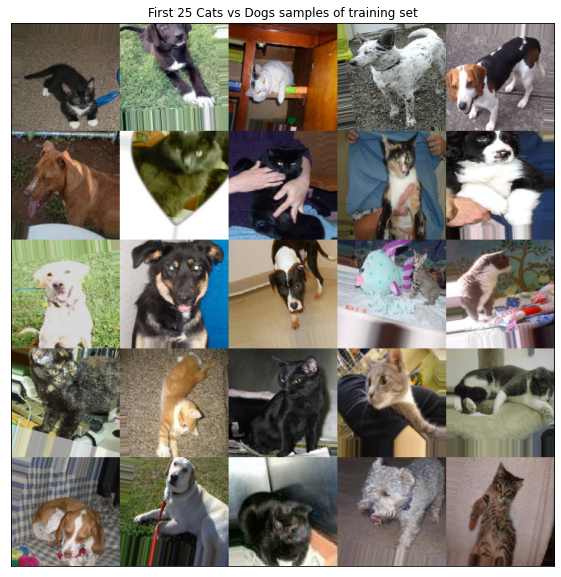

In [81]:
LABEL_DICT={1:'dog',0:'cat'}

for img in train_generator:
  img=img[0]
  break

plot_dataset_samples_grid(img,'Cats vs Dogs', N=5)

In [82]:
vgg_model_2 = vgg.VGG16(weights='imagenet', 
                       include_top=False)

In [83]:
vgg_model_2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [84]:
last = vgg_model_2.get_layer('block5_pool').output

x = GlobalAveragePooling2D()(last)
x = BatchNormalization()(x)

x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(1, activation='sigmoid')(x)

In [85]:
fin_model_2 = Model(vgg_model_2.input, pred)

In [86]:
for layer in vgg_model_2.layers[:15]:
     layer.trainable = False

In [87]:
fin_model_2.compile(loss='binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['accuracy'])

In [88]:
fin_model_2.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

In [89]:
history_cnn = fin_model_2.fit_generator(train_generator,
              epochs=10,
              validation_data=test_generator,
              shuffle=True)

Epoch 1/10
176/176 [==============================] - 177s 1s/step - loss: 0.2487 - accuracy: 0.8950 - val_loss: 0.1480 - val_accuracy: 0.9376
Epoch 2/10
176/176 [==============================] - 170s 967ms/step - loss: 0.1674 - accuracy: 0.9313 - val_loss: 0.2130 - val_accuracy: 0.9024
Epoch 3/10
176/176 [==============================] - 170s 967ms/step - loss: 0.1476 - accuracy: 0.9391 - val_loss: 0.2723 - val_accuracy: 0.8672
Epoch 4/10
176/176 [==============================] - 171s 969ms/step - loss: 0.1275 - accuracy: 0.9476 - val_loss: 0.2948 - val_accuracy: 0.9428
Epoch 5/10
176/176 [==============================] - 170s 968ms/step - loss: 0.1159 - accuracy: 0.9553 - val_loss: 0.1528 - val_accuracy: 0.9576
Epoch 6/10
176/176 [==============================] - 171s 969ms/step - loss: 0.1029 - accuracy: 0.9595 - val_loss: 0.2954 - val_accuracy: 0.9276
Epoch 7/10
176/176 [==============================] - 170s 968ms/step - loss: 0.0921 - accuracy: 0.9620 - val_loss: 0.1013 - va

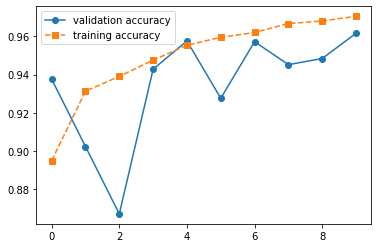

In [90]:
plt.plot(history_cnn.history['val_accuracy'], '-o', label='validation accuracy')
plt.plot(history_cnn.history['accuracy'], '--s', label='training accuracy')
plt.legend()

In [91]:
fin_model_2.evaluate(test_generator)

20/20 [==============================] - 8s 409ms/step


[0.20599153637886047, 0.9616000056266785]

In [92]:
im1, im2, im3 = load_special_images()

In [93]:
im1_150 = image_to_batch(im1, 150)
im2_150 = image_to_batch(im2, 150)
im3_150 = image_to_batch(im3, 150)

In [94]:
im1_150 = im1_150/255.
im2_150 = im2_150/255.
im3_150 = im3_150/255.

In [95]:
pred1 = fin_model_2.predict(im1_150)
pred2 = fin_model_2.predict(im2_150)
pred3 = fin_model_2.predict(im3_150)
print(pred1, pred2, pred3)

[[0.17715605]] [[0.56576675]] [[0.00603788]]


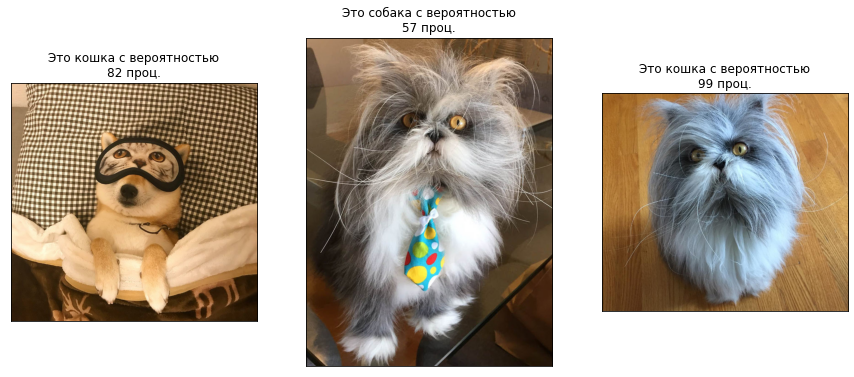

In [96]:
plot_special_images(pred1,pred2,pred3)

In [97]:
# Создадим генератор картинок из тестовой выборки
test_generator_2 = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=200,
        class_mode='binary',shuffle=False)

Found 2500 images belonging to 2 classes.


In [98]:
preds_labels, preds_vec, labels_vec, datas_vec = get_test_predictions(test_generator_2, fin_model_2)

In [99]:
errors = labels_vec!=preds_labels

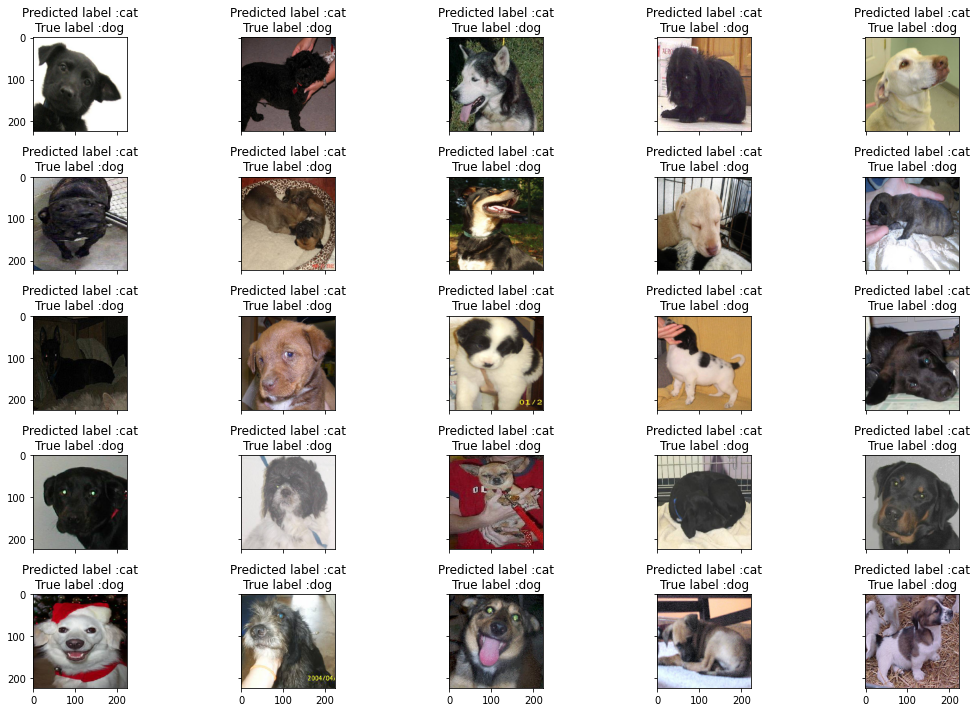

In [100]:
# Выделим из векторов предсказаний и настоящих лейблов только те,
# где нейросеть допустила ошибку
Y_pred_classes_errors = preds_labels[errors]
Y_pred_errors = preds_vec[errors]
Y_true_errors = labels_vec[errors]
X_val_errors = datas_vec[errors]

# Вероятности неправильно предсказанных классов
Y_pred_errors_prob = Y_pred_errors

# Вероятности, соответствующие правильным классам
true_prob_errors = 1-Y_pred_errors

# Разница вероятностей правильного и неправильного классов
delta_pred_true_errors = np.abs(Y_pred_errors_prob - true_prob_errors)

# Отсортированный списоц разниц вероятностей
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# 25 наибольших ошибок
most_important_errors = sorted_dela_errors[-25:]

# Построим самые ошибочные rfhnbyrb
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [101]:
df = pd.DataFrame(
    [
     [len(labels_vec), len(labels_vec[labels_vec==0]), len(labels_vec[labels_vec==0])],
     [len(errors[errors==1]), len(Y_pred_classes_errors[Y_pred_classes_errors==1]), len(Y_pred_classes_errors[Y_pred_classes_errors==0])],
     [(len(errors[errors==1])/len(labels_vec))*100, (len(Y_pred_classes_errors[Y_pred_classes_errors==1])/ len(labels_vec[labels_vec==0]))*100, (len(Y_pred_classes_errors[Y_pred_classes_errors==0])/ len(labels_vec[labels_vec==0]))*100 ]
     ],  columns=["All_test","cats","dogs"], index=["test_set", "errors", "errors_percent"])
#df.index = [["test_set"], ["errors"], ["errors_percent"]]
df

,All_test,cats,dogs
test_set,2500.00,1250.00,1250.00
errors,219.00,11.00,208.00
errors_percent,8.76,0.88,16.64
